In [555]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.cross_validation import cross_val_predict
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_validation import KFold
# from sklearn.model_selection import train_test_split
%matplotlib inline
%precision %.2f

u'%.2f'

In [556]:
usnews = pd.read_csv("USNewsCollegeRankings2018.csv")
usnews.set_index('University', inplace=True)
usnews.head()

,City,State,Rank,In-state Tuition,Out-state Tuition,Enrollment
University,,,,,,
Princeton University,Princeton,NJ,1,$47140,$47140,"5,400.00"
Harvard University,Cambridge,MA,2,$48949,$48949,"6,710.00"
University of Chicago,Chicago,IL,3,$54825,$54825,"5,941.00"
Yale University,New Haven,CT,3,$51400,$51400,"5,472.00"
Columbia University,New York,NY,5,$57208,$57208,"6,113.00"


In [557]:
# dem = pd.read_csv("demographic_income_data.csv", header=None, names=['desc', 'value'])
# dem.head()

In [558]:
scorecard = pd.read_csv("CollegeScorecard_Raw_Data/MERGED2015_16_PP.csv")
scorecard.shape

(7593, 1777)

In [559]:
usnews=usnews[usnews['Rank']!= 'Rank Not Published']
usnews=usnews[usnews['Rank']!= 'Unranked']
usnews.shape

(230, 6)

In [560]:
drop=['\xef\xbb\xbfUNITID','OPEID','OPEID6','CITY','STABBR','ZIP','ACCREDAGENCY','INSTURL','NPCURL']
scorecard.drop(drop, axis=1, inplace=True)
scorecard.set_index('INSTNM',inplace=True)
scorecard = scorecard.loc[usnews.index]
scorecard['Rank']=usnews['Rank']
scorecard.shape

(230, 1768)

In [561]:
# scorecard.dropna(axis=1,thresh=100).shape
data = scorecard.dropna(thresh=100, axis=1).dropna(thresh=500)
for c in data.columns.values:
    data[c] = pd.to_numeric(data[c], errors='coerce')
data.dropna(axis=1,thresh=100, inplace=True)
# data.fillna(data.mean, inplace=True)
cols=[]
for c in data.columns.values:
    if data[c].var()!=0:
       cols.append(c)
data=data[cols]

In [562]:
def normalize(df):
    return(df - df.mean()) / df.std()

scnorm = normalize(data)
scnorm.shape

(142, 441)

In [563]:
# create groups based on median family income - high, low
groups = pd.DataFrame()
groups['MD_FAMINC']= data['MD_FAMINC']
data.drop(['MD_FAMINC'], axis=1, inplace=True)
m = groups['MD_FAMINC'].mean()
groups.loc[groups['MD_FAMINC'] >m,'Group'] = 0
groups.loc[groups['MD_FAMINC'] <=m,'Group'] = 1
X = np.nan_to_num(scnorm.drop(['Rank'], axis=1))
y = np.nan_to_num(scnorm['Rank'])f

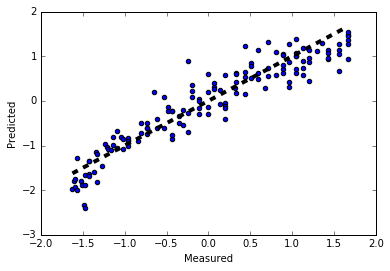

('Overall MSE: ', 0.1197945853263323)


In [564]:
lr = linear_model.LinearRegression()

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
pred = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, pred, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

print("Overall MSE: ",  mean_squared_error(y, pred))

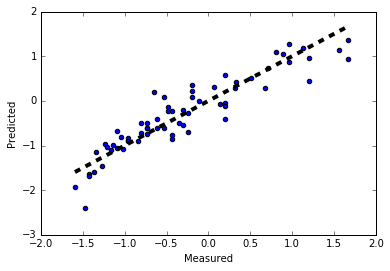

('Group0 MSE: ', 0.10583062977282344)


In [565]:
y0 = y[np.nan_to_num(groups['Group'] == 0)]
pred0 = pred[np.nan_to_num(groups['Group'] == 0)]

fig, ax = plt.subplots()
ax.scatter(y0, pred0, edgecolors=(0, 0, 0))
ax.plot([y0.min(), y0.max()], [y0.min(), y0.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
print("Group0 MSE: ",  mean_squared_error(y0, pred0))

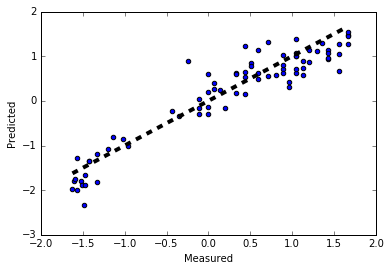

('Group1 MSE: ', 0.13158234001435926)


In [566]:
y1 = y[np.nan_to_num(groups['Group'] == 1)]
pred1 = pred[np.nan_to_num(groups['Group'] == 1)]
fig, ax = plt.subplots()
ax.scatter(y1, pred1, edgecolors=(0, 0, 0))
ax.plot([y1.min(), y1.max()], [y1.min(), y1.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
print("Group1 MSE: ",  mean_squared_error(y1, pred1))

In [567]:
def get_binned_eq_depth(points, n_folds=10):
    pred = []
    y = []
    kf = KFold(len(points), n_folds=n_folds)
    print kf
    for rest, bin in kf:
        vals = [points[i] for i in bin]
        m_pred = np.mean([x[0] for x in vals])
        m_y = np.mean([x[1] for x in vals])
        pred.append([m_pred])
        y.append([m_y])
    return pred,y

In [575]:
def get_bin_width(data, n):
    return (data.max()-data.min())/(n+1)
    
def get_binned_eq_width(points, min_val, width, n):
    bins=[]
    b=[]
    w = min_val+width
#     c=1
    for i in range(len(points)):
        if(points[i][0] < w):
            b.append(points[i])
        else:
#             print("bin: "+str(c), b)
#             print
            m_pred = np.mean([x[0] for x in b])
            m_y = np.mean([x[1] for x in b])
            bins.append([m_pred, m_y])
            b=[]
            w+=width
#             print"w:",w
#             print
#             c+=1
    return np.asarray(bins)    
            

In [576]:
points1 = zip(pred1,y1)
points1.sort(key=lambda x:x[0])
points0 = zip(pred0,y0)
points0.sort(key=lambda x:x[0])

In [577]:
w = get_bin_width(pred,10)
print w
print("Group 1: ")
bins0 = get_binned_eq_width(points0, pred.min(), w, 10)
print(bins0)
print("Group 2")
bins1 = get_binned_eq_width(points1, pred.min(), w, 10)
print(bins1)

0.357919341667
Group 1: 
[[-2.39057734 -1.4753292 ]
 [-1.67891321 -1.43088466]
 [-1.52610848 -1.31977331]
 [-1.03823689 -1.14199515]
 [-0.73542046 -0.73458687]
 [-0.43100616 -0.42594423]
 [-0.07046017 -0.17491488]
 [ 0.33621334  0.31303443]
 [ 0.65811685  0.45800829]
 [ 1.06320313  1.21109633]]
Group 2
[[-2.33159463 -1.49014405]
 [-1.84019277 -1.52189015]
 [-1.34277585 -1.43088466]
 [-1.0892189  -1.15927914]
 [-0.80251009 -1.13458773]
 [-0.29835623 -0.06051135]
 [-0.10324004 -0.00865938]
 [ 0.29210506  0.36171178]
 [ 0.64815589  0.75038365]
 [ 1.02092129  1.09949115]]


In [578]:
# x0,y0 = get_binned_eq_depth(points0, 10)
# x1,y1 = get_binned_eq_depth(points1, 10)

In [579]:
# reliability curve
# probem is that the regression predictions will always be much closer to the diagonal 
# than the reliability curve for the probabilistic classifier

# plt.plot(x1,y1, marker='o')
# plt.plot(x0,y0, marker='*')
# plt.plot(x0,x0)
# plt.show()

In [580]:
# TODO: how to handle empty bin?
# can drop, or set error =0, but that is misleading
print bins0.shape
print bins1.shape
bins1 = bins1[:-1]

(10, 2)
(10, 2)


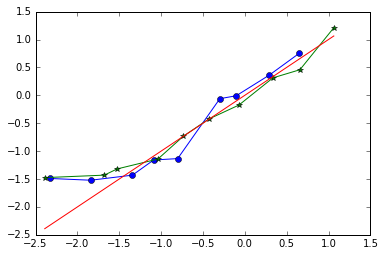

In [581]:
# reliability curve
# probem is that the regression predictions will always be much closer to the diagonal 
# than the reliability curve for the probabilistic classifier

plt.plot(bins1[:,0],bins1[:,1], marker='o')
plt.plot(bins0[:,0],bins0[:,1], marker='*')
plt.plot(bins0[:,0],bins0[:,0])
plt.show()

In [589]:
def get_mse_binned_eq_depth(pred, true, n_folds=10):
    points = zip(pred,true)
    points.sort(key=lambda x:x[0])
    mse = []
    kf = KFold(len(points), n_folds=n_folds)
    print kf
    for rest, bin in kf:
        vals = [points[i] for i in bin]
        m = np.sum([math.pow(x[0]-x[1], 2) for x in vals])
        m = m/len(vals)
        mse.append(m)
    return mse

In [590]:
def get_mse_binned_eq_width(points, min_val, width):
    bins=[]
    b=[]
    w = min_val+width
#     c=1
    for i in range(len(points)):
        if(points[i][0] < w):
            b.append(points[i])
        else:
#             print("bin: "+str(c), b)
#             print
            m = np.sum([math.pow(x[0]-x[1], 2) for x in b])
            m = m/len(b)
            bins.append(m)
            b=[]
            w+=width
#             c+=1
    return np.asarray(bins)   

In [591]:
def plot_cal_error(df):
    indices =np.arange(df.shape[0])
    #Calculate optimal width
    width = 0.3

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(indices-width,df['mse0'],width,color='b',label='-Ymin')
    ax.bar(indices,df['mse1'],width,color='r',label='Ymax')
    ax.set_xlim(left=-1,right=10)
    ax.set_xlabel('Bin')
    ax.set_ylabel('MSE')
    plt.show()



In [592]:
def plot_cal_norm(df):
    norm = (df-df.mean()).abs()
    
    indices =np.arange(df.shape[0])
    #Calculate optimal width
    width = 0.3
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(indices-width,norm['mse0'],width,color='b',label='-Ymin')
    ax.bar(indices,norm['mse1'],width,color='r',label='Ymax')
    ax.set_xlim(left=-1,right=10)
    ax.set_xlabel('Bin')
    ax.set_ylabel('MSE')
    plt.show()



In [596]:
mse_df = pd.DataFrame()
mse_df['mse0'] = get_mse_binned_eq_width(points0,pred.min(),w)
#Using equal width plomse_df['mse1'] = get_mse_binned_eq_width(points1,pred.min(),w)

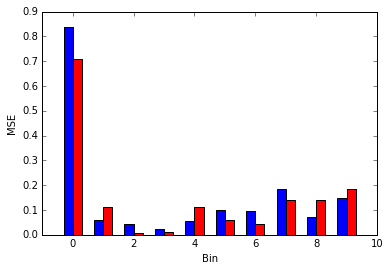

In [597]:
# using equal width bins  - which one gives more comparable plot?
plot_cal_error(mse_df)

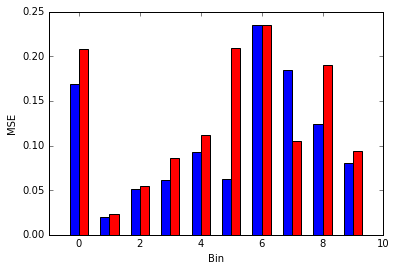

In [598]:
# using equal depth bins
plot_cal_error(df)

In [253]:
# overall = pd.DataFrame()
# overall['y']=y
# overall['pred']=pred
# overall['SE'] = pow((overall['y']-overall['pred']),2)

# g0 = pd.DataFrame()
# g0['y']=y0
# g0['pred']=pred0
# g0['SE'] = pow((g0['y']-g0['pred']),2)

# g1 = pd.DataFrame()
# g1['y']=y1
# g1['pred']=pred1
# g1['SE'] = pow((g1['y']-g1['pred']),2)

In [26]:
overall.sort('pred',inplace=True)
g1.sort('pred',inplace=True)
g1.sort('pred',inplace=True)

/home/caitlin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/home/caitlin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/home/caitlin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [27]:
# histogram of error is like density estimation - maybe we use a kernel method or something

In [28]:
pd.options.display.float_format = '{:,.2f}'.format

In [29]:
#should be squared error or absolute?
def getOverUnder(df):
    diff = df['y'] - df['pred']
    df.loc[diff <0,'over'] = 0
    df.loc[diff >0,'over'] = pow(diff,2)
    df.loc[diff <0,'under'] = pow(diff,2)
    df.loc[diff >0,'under'] = 0
    df['all'] = pow(diff,2)

In [30]:
getOverUnder(overall)
print("MSE overall: ", overall['all'].mean())
print("Overestimated overall: ", overall['over'].mean())
print("Underestimated overall: ", overall['under'].mean())
print
getOverUnder(g0)
print("MSE Group 2: ", g0['all'].mean())
print("Overestimated g0: ", g0['over'].mean())
print("Underestimated g0: ", g0['under'].mean())
print
getOverUnder(g1)
print("MSE Group 1: ", g1['all'].mean())
print("Overestimated g1: ", g1['over'].mean())
print("Underestimated g1: ", g1['under'].mean())

('MSE overall: ', 0.11978610079284367)
('Overestimated overall: ', 0.07005891155625993)
('Underestimated overall: ', 0.04972718923658371)

('MSE Group 2: ', 0.10582272898837913)
('Overestimated g0: ', 0.05980167058763785)
('Underestimated g0: ', 0.04602105840074127)

('MSE Group 1: ', 0.13157336270570325)
('Overestimated g1: ', 0.07871762146483705)
('Underestimated g1: ', 0.05285574124086627)


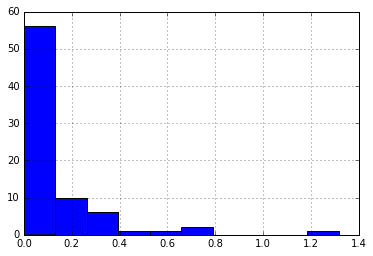

In [31]:
g1['all'].hist()

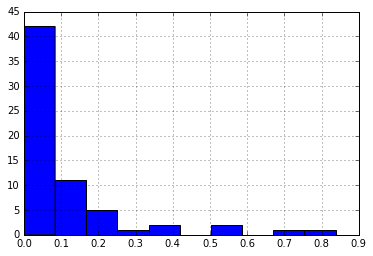

In [32]:
g0['all'].hist()

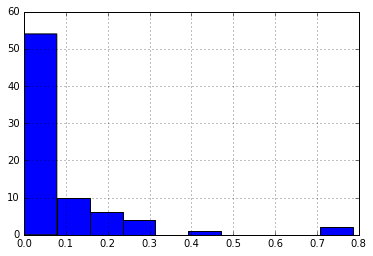

In [33]:
g1['over'].hist()

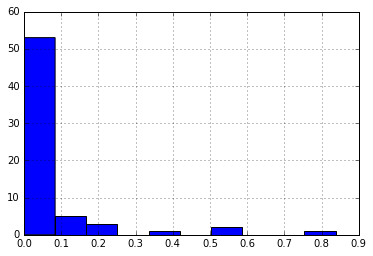

In [34]:
g0['over'].hist()

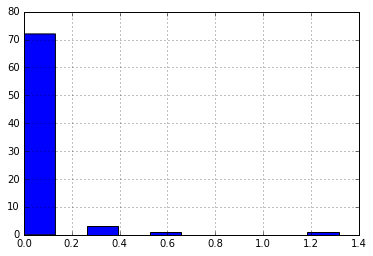

In [35]:
g1['under'].hist()

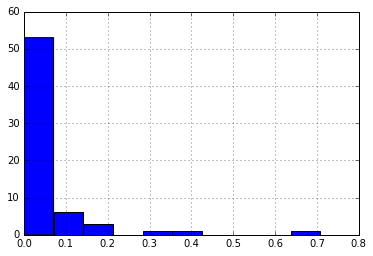

In [36]:
g0['under'].hist()

In [37]:
print scnorm['Rank'].max()
print scnorm['Rank'].min()

1.66541829325
-1.62347767094


In [38]:
print data['Rank'].max()
print data['Rank'].min()

223
1


In [39]:
m = data['Rank'].mean()
st = data['Rank'].std()

In [ ]:
tmp = g0['over'] - g1['']